In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.signal import detrend

# Load CSV file
def load_data(filename):
    """
    Load voltage vs. time data from a CSV file.
    Assumes the file has columns: Time (s), Channel 1 (V), Channel 2 (V).
    """

    try:
        # Load the CSV with proper header handling
        data = pd.read_csv(filename, skiprows=23)  # First row is the header
        data.columns = data.columns.str.strip()  # Clean up column names

        # Extract relevant columns
        time = data["Time (s)"]
        tia = data["Channel 1 (V)"]
        bpf = data["Channel 2 (V)"]
        da = data["Channel 3 (V)"]
        levelShifter = data["Channel 4 (V)"]

        return time, tia, bpf, da, levelShifter
        # return time, tia
    except pd.errors.ParserError as e:
        print(f"ParserError: {e}")
        raise
    except KeyError as e:
        print(f"KeyError: {e}. Check column names in the CSV file.")
        raise

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend, find_peaks

# Calculate RMS voltage
def calculate_rms(voltage):
    return np.sqrt(np.mean(np.square(voltage)))

# Compute SNR
# Compute SNR correctly with power ratio
def calc_snr(signal, noise):
    signal_rms = calculate_rms(signal)
    noise_rms = calculate_rms(noise)

    # Use squared RMS values (since power is proportional to squared voltage)
    return 10 * np.log10((signal_rms ** 2) / (noise_rms ** 2))


# Perform FFT and apply a frequency mask
def fft_bandpass_filter(signal, sampling_rate, target_freq, bandwidth=5000):
    """
    Filters the signal in the frequency domain using a bandpass mask.
    - target_freq: The frequency of interest (Hz)
    - bandwidth: The range around the target frequency to keep
    """
    N = len(signal)
    fft_output = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, 1 / sampling_rate)

    # Create a mask that keeps only frequencies within the specified bandwidth
    mask = (np.abs(freqs) >= (target_freq - bandwidth/2)) & (np.abs(freqs) <= (target_freq + bandwidth/2))

    # Apply the mask (zero out unwanted frequencies)
    filtered_fft = fft_output * mask

    # Inverse FFT to get filtered signal
    filtered_signal = np.fft.ifft(filtered_fft).real

    return filtered_signal, freqs, np.abs(fft_output), np.abs(filtered_fft)


In [ ]:
def process_data_and_snr(filename, signal_start, signal_end, led_freq, sampling_rate, bandwidth=5000):
    """
    Processes the signal by filtering around the LED frequency in the frequency domain
    and calculates SNR for each channel.
    """
    # Load data
    time, tia, bpf, da, levelShifter = load_data(filename)

    # Get the signals for the specified time range
    tia_signal = tia[(time >= signal_start) & (time <= signal_end)]
    bpf_signal = bpf[(time >= signal_start) & (time <= signal_end)]
    da_signal = da[(time >= signal_start) & (time <= signal_end)]
    levelShifter_signal = levelShifter[(time >= signal_start) & (time <= signal_end)]

    # Detrend signals
    tia_no_dc = detrend(tia_signal)
    bpf_no_dc = detrend(bpf_signal)
    da_no_dc = detrend(da_signal)
    levelShifter_no_dc = detrend(levelShifter_signal)

    # Apply Fourier domain bandpass filtering
    filtered_tia, _, _, _ = fft_bandpass_filter(tia_no_dc, sampling_rate, led_freq, bandwidth)
    filtered_bpf, _, _, _ = fft_bandpass_filter(bpf_no_dc, sampling_rate, led_freq, bandwidth)
    filtered_da, _, _, _ = fft_bandpass_filter(da_no_dc, sampling_rate, led_freq, bandwidth)
    filtered_ls, _, _, _ = fft_bandpass_filter(levelShifter_no_dc, sampling_rate, led_freq, bandwidth)

    # Calculate noise for each stage (residual signal)
    noise_tia = tia_no_dc - np.mean(tia_no_dc)
    noise_bpf = bpf_no_dc - filtered_bpf
    noise_da = da_no_dc - filtered_da
    noise_ls = levelShifter_no_dc - filtered_ls

    def estimate_noise_from_psd(signal, sampling_rate, exclude_band=(19200, 20500)):
        """
        Estimate noise power from the PSD of the signal, excluding the band where the LED signal is.
        exclude_band: tuple of (low_freq, high_freq) to exclude the signal of interest.
        """
        from scipy.signal import welch

        freqs, psd = welch(signal, fs=sampling_rate, nperseg=1024)
        # Create a mask for frequencies outside the LED band
        noise_mask = (freqs < exclude_band[0]) | (freqs > exclude_band[1])
        # Average the PSD over the noise regions
        noise_power = np.mean(psd[noise_mask])
        noise_rms = np.sqrt(noise_power)
        return noise_rms

    # TIA noise
    noise_rms_estimated = estimate_noise_from_psd(tia_no_dc, sampling_rate)
    signal_rms = calculate_rms(filtered_tia)
    snr_db_tia = 10 * np.log10((signal_rms**2) / (noise_rms_estimated**2))
    print("Estimated SNR Channel 1 (dB):", snr_db_tia)

    # BPF noise
    noise_rms_estimated = estimate_noise_from_psd(bpf_no_dc, sampling_rate)
    signal_rms = calculate_rms(filtered_bpf)
    snr_db_bpf = 10 * np.log10((signal_rms**2) / (noise_rms_estimated**2))
    print("Estimated SNR Channel 2 (dB) after BPF:", snr_db_bpf)

    # DA noise
    noise_rms_estimated = estimate_noise_from_psd(da_no_dc, sampling_rate)
    signal_rms = calculate_rms(filtered_da)
    snr_db_da = 10 * np.log10((signal_rms**2) / (noise_rms_estimated**2))
    print("Estimated SNR (dB) Channel 3:", snr_db_da)

    # CHANNEL 4
    noise_rms_estimated = estimate_noise_from_psd(levelShifter_no_dc, sampling_rate)
    signal_rms = calculate_rms(filtered_ls)
    snr_db_da = 10 * np.log10((signal_rms**2) / (noise_rms_estimated**2))
    print("Estimated SNR (dB) Channel 4:", snr_db_da)



    def plot_fft(signal, sampling_rate, label):
        N = len(signal)
        fft_output = np.fft.fft(signal)
        freqs = np.fft.fftfreq(N, 1 / sampling_rate)
        peaks = find_peaks(fft_output)


        print("the max of the frequency value occurs at: ", find_peaks(fft_output)[0])
        plt.plot(fft_output)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.legend()

    # Compute FFT before and after BPF
    plt.figure(figsize=(10, 5))
    plot_fft(tia_no_dc, sampling_rate, label="Before BPF")
    # plot_fft(bpf_no_dc, sampling_rate, label="After BPF")
    plt.title("FFT of Signal Before and After BPF")
    plt.show()


    # return snr_tia, snr_bpf, snr_da, snr_ls
    return snr_db_tia


In [ ]:
# process the data
import os

signal_start = -0.035
signal_end = 0.037
noise_start = -0.035
noise_end = 0.037
sampling_freq = 5.55556e6 # corrected from the csv file

Processing file '/content/drive/MyDrive/Prototype Testing/March 23 Data collection/mar23_BPF_DA_CMP_LS_hello_world.csv'
Estimated SNR Channel 1 (dB): 59.516673008624224
Estimated SNR Channel 2 (dB) after BPF: 59.325912373142984
Estimated SNR (dB) Channel 3: 62.68582925656197
Estimated SNR (dB) Channel 4: 62.70672638962088
the max of the frequency value occurs at:  [    4     6     8 ... 32760 32762 32764]


/usr/local/lib/python3.11/dist-packages/scipy/signal/_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
<ipython-input-7-f00a1c0ed409>:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


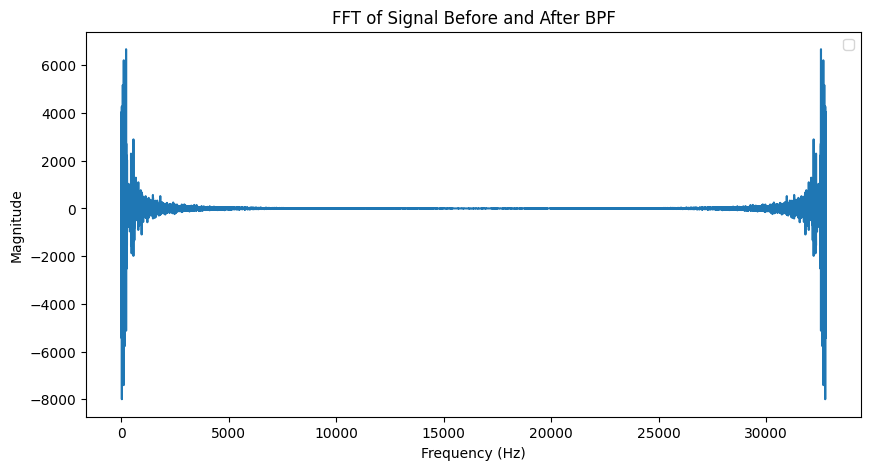

[np.float64(59.516673008624224)]


In [ ]:
file = "/content/drive/MyDrive/Prototype Testing/March 23 Data collection/mar23_BPF_DA_CMP_LS_hello_world.csv"
print(f"Processing file '{file}'")
snr_tia = process_data_and_snr(file, signal_start, signal_end, 20e3, sampling_freq)
channels = ['TIA']
snr_values = [snr_tia]
print(snr_values)


In [ ]:
# 5kHz -> 61.46dB of SNR
# 10kHz -> 60.835dB of SNR
# 15kHz -> 58.78dB of SNR
# 20kHz -> 44.59dB of SNR
# 40KHZ -> 27.8dB of SNR
# 45kHz -> 27.72dB of SNR

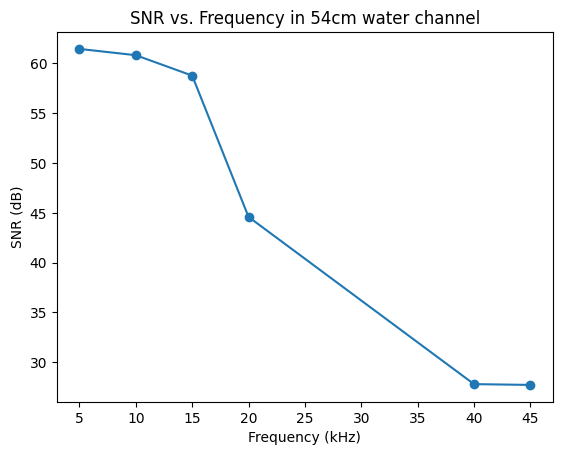

In [ ]:
freqs = [5, 10, 15, 20, 40, 45]
vals = [61.46, 60.83, 58.78, 44.59, 27.8, 27.72]

plt.plot(freqs, vals, 'o-')
plt.ylabel("SNR (dB)")
plt.xlabel("Frequency (kHz)")
plt.title("SNR vs. Frequency in 54cm water channel")
plt.show()